In [2]:
import sys
sys.path.append('../')
import pickle
from preprocessing.imdb_datareader import IMDBDataReader
from preprocessing.factorization_machine_transformer import  FactorizationMachineTransformer

user_item  = pickle.load(open("data/user_item.p", "rb")) 
users = {}
items = {}
train_user_item = user_item[:int(len(user_item)*0.8)]
test_user_item = user_item[int(len(user_item)*0.8):]
transformer = FactorizationMachineTransformer(users, items, train_user_item)
X_train, Y_train, _, _, nFeatures = transformer.get_feature_vectors(users, items, train_user_item)
X_test, Y_test,X_cold_test, Y_cold_test, nFeatures = transformer.get_feature_vectors(users, items, test_user_item)

In [3]:
X_test.shape

(2863, 2367)

In [4]:
!aws s3api create-bucket --bucket recommendation-demo-yianc-0814 --region us-west-2 --create-bucket-configuration LocationConstraint=us-west-2


An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


In [5]:
bucket = 'recommendation-demo-yianc'
prefix = 'sagemaker/fm-movielens-ui'
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')
output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)


import io,boto3
import sagemaker.amazon.common as smac

def writeDatasetToProtobuf(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type == "sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
 
    
train_data = writeDatasetToProtobuf(X_train, bucket, train_prefix, train_key, "sparse", Y_train)    
  
print('Output: {}'.format(output_prefix))

Output: s3://recommendation-demo-yianc/sagemaker/fm-movielens-ui/output


In [6]:
train_data 

's3://recommendation-demo-yianc/sagemaker/fm-movielens-ui/train/train.protobuf'

In [7]:
from sagemaker import get_execution_role
import boto3 
from sagemaker.amazon.amazon_estimator import get_image_uri
region = boto3.Session().region_name
container = get_image_uri(region, 'factorization-machines', 'latest')
container


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


'382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:latest'

In [8]:
import boto3 
import sagemaker
from sagemaker import get_execution_role

crole = get_execution_role() 

dir(sagemaker.estimator.Estimator)
fm = sagemaker.estimator.Estimator(container,
                                   crole, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())



fm.set_hyperparameters(
                      feature_dim=nFeatures,
                      predictor_type='binary_classifier',
#                       predictor_type='regressor',
                      mini_batch_size=200,
                      num_factors=64,
                      epochs=50)

fm.fit({'train': train_data})


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-16 06:18:45 Starting - Starting the training job...
2020-08-16 06:18:47 Starting - Launching requested ML instances.........
2020-08-16 06:20:29 Starting - Preparing the instances for training......
2020-08-16 06:21:43 Downloading - Downloading input data...
2020-08-16 06:22:14 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[08/16/2020 06:22:20 INFO 140376510879552] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001',

[2020-08-16 06:22:23.785] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 6, "duration": 967, "num_examples": 400, "num_bytes": 5120000}
[08/16/2020 06:22:23 INFO 140376510879552] #quality_metric: host=algo-1, epoch=2, train rmse <loss>=0.469350672827
[08/16/2020 06:22:23 INFO 140376510879552] #quality_metric: host=algo-1, epoch=2, train mse <loss>=0.220290054083
[08/16/2020 06:22:23 INFO 140376510879552] #quality_metric: host=algo-1, epoch=2, train absolute_loss <loss>=0.449622859907
#metrics {"Metrics": {"update.time": {"count": 1, "max": 969.7470664978027, "sum": 969.7470664978027, "min": 969.7470664978027}}, "EndTime": 1597558943.786507, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597558942.816339}

[08/16/2020 06:22:23 INFO 140376510879552] #progress_metric: host=algo-1, completed 6 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 400, "s

[2020-08-16 06:22:33.124] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 26, "duration": 899, "num_examples": 400, "num_bytes": 5120000}
[08/16/2020 06:22:33 INFO 140376510879552] #quality_metric: host=algo-1, epoch=12, train rmse <loss>=0.431395419343
[08/16/2020 06:22:33 INFO 140376510879552] #quality_metric: host=algo-1, epoch=12, train mse <loss>=0.18610200783
[08/16/2020 06:22:33 INFO 140376510879552] #quality_metric: host=algo-1, epoch=12, train absolute_loss <loss>=0.392799392605
#metrics {"Metrics": {"update.time": {"count": 1, "max": 902.2290706634521, "sum": 902.2290706634521, "min": 902.2290706634521}}, "EndTime": 1597558953.124873, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597558952.222214}

[08/16/2020 06:22:33 INFO 140376510879552] #progress_metric: host=algo-1, completed 26 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 400

[2020-08-16 06:22:48.916] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 60, "duration": 887, "num_examples": 400, "num_bytes": 5120000}
[08/16/2020 06:22:48 INFO 140376510879552] #quality_metric: host=algo-1, epoch=29, train rmse <loss>=0.41362529447
[08/16/2020 06:22:48 INFO 140376510879552] #quality_metric: host=algo-1, epoch=29, train mse <loss>=0.171085884225
[08/16/2020 06:22:48 INFO 140376510879552] #quality_metric: host=algo-1, epoch=29, train absolute_loss <loss>=0.361854017186
#metrics {"Metrics": {"update.time": {"count": 1, "max": 889.6040916442871, "sum": 889.6040916442871, "min": 889.6040916442871}}, "EndTime": 1597558968.917313, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1597558968.027016}

[08/16/2020 06:22:48 INFO 140376510879552] #progress_metric: host=algo-1, completed 60 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 400

[08/16/2020 06:22:58 INFO 140376510879552] #quality_metric: host=algo-1, epoch=40, batch=0 train rmse <loss>=0.396780600547
[08/16/2020 06:22:58 INFO 140376510879552] #quality_metric: host=algo-1, epoch=40, batch=0 train mse <loss>=0.157434844971
[08/16/2020 06:22:58 INFO 140376510879552] #quality_metric: host=algo-1, epoch=40, batch=0 train absolute_loss <loss>=0.354808158875
[2020-08-16 06:22:58.991] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 82, "duration": 902, "num_examples": 400, "num_bytes": 5120000}
[08/16/2020 06:22:58 INFO 140376510879552] #quality_metric: host=algo-1, epoch=40, train rmse <loss>=0.421914589953
[08/16/2020 06:22:58 INFO 140376510879552] #quality_metric: host=algo-1, epoch=40, train mse <loss>=0.178011921215
[08/16/2020 06:22:58 INFO 140376510879552] #quality_metric: host=algo-1, epoch=40, train absolute_loss <loss>=0.355444239569
#metrics {"Metrics": {"update.time": {"count": 1, "max": 905.1380157470703, "sum": 905.13


2020-08-16 06:23:18 Uploading - Uploading generated training model
2020-08-16 06:23:18 Completed - Training job completed
Training seconds: 95
Billable seconds: 95


In [9]:
fm_predictor = fm.deploy(instance_type='ml.c4.xlarge', initial_instance_count=1)


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

In [10]:

sys.path.append('../')
import sagemaker_utils
from sagemaker_utils.query_serializer import serialize as fmserialize 
from sagemaker.predictor import  json_deserializer
from sklearn.metrics import accuracy_score
import numpy 


sagemaker_utils.query_serializer.nFeatures = nFeatures
fm_predictor.content_type = sagemaker_utils.query_serializer.CONTENT_TYPE
fm_predictor.serializer = fmserialize
fm_predictor.deserializer = json_deserializer



def model_accuracy(X_test, Y_test): 
    X_test_arr = X_test
        
    result = fm_predictor.predict(X_test_arr) 
    y_pred = [] 
    for p in result['predictions']: 
        if p['score'] > 0.5:
            y_pred.append(1)
        else: 
            y_pred.append(0)
    return accuracy_score(Y_test, y_pred, normalize=False)


In [11]:
rmse = model_accuracy(X_test, Y_test) / len(Y_test)
rmse

0.675864477820468

In [12]:
rmse = model_accuracy(X_cold_test, Y_cold_test) / len(Y_cold_test)
rmse

0.5617977528089888

In [13]:
import os 
model_file_name = "model.tar.gz"
model_full_path = fm.output_path +"/"+ fm.latest_training_job.job_name +"/output/"+model_file_name
print ("Model Path: ", model_full_path)

#Download FM model 
os.system("aws s3 cp "+model_full_path+ " .")

#Extract model file for loading to MXNet
os.system("tar xzvf "+model_file_name)
os.system("unzip -o model_algo-1")
os.system("mv symbol.json model-symbol.json")
os.system("mv params model-0000.params")


Model Path:  s3://recommendation-demo-yianc/sagemaker/fm-movielens-ui/output/factorization-machines-2020-08-16-06-18-45-606/output/model.tar.gz


0

In [14]:
!pip install mxnet 

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [15]:
#Extract model data
import mxnet as mx
import numpy as np 

nb_users = len(transformer.u_idx) 
nb_movies = len(transformer.i_idx) 
print(nb_users, nb_movies)
m = mx.module.Module.load('./model', 0, False, label_names=['out_label'])


V = m._arg_params['v'].asnumpy()
w = m._arg_params['w1_weight'].asnumpy()
b = m._arg_params['w0_weight'].asnumpy()


# item latent matrix - concat(V[i], w[i]).  
knn_item_matrix = np.concatenate((V[nb_users:(nb_users+nb_movies)], w[nb_users:(nb_users+nb_movies)]), axis=1)
knn_train_label = np.arange(1,nb_movies+1)

#user latent matrix - concat (V[u], 1) 
ones = np.ones(nb_users).reshape((nb_users, 1))
knn_user_matrix = np.concatenate((V[:nb_users], ones), axis=1)

751 1616


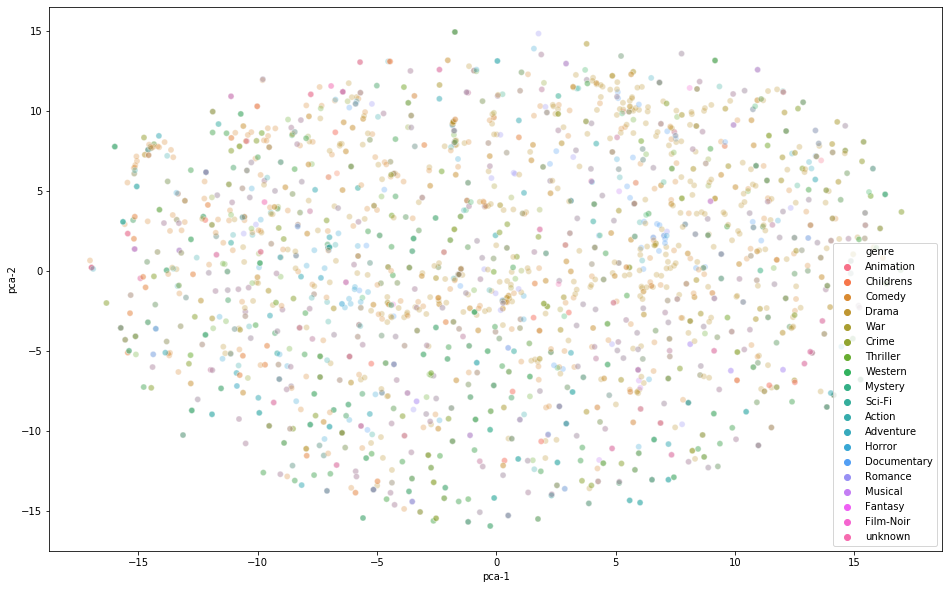

In [47]:
item_df = pd.read_pickle("data/item_df.p")
genres = ['unknown','Action' , 'Adventure', 'Animation', 'Childrens' , 'Comedy' , 'Crime', \
                                        'Documentary', 'Drama' ,'Fantasy' , 'Film-Noir' , 'Horror' , 'Musical', \
                                        'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

user_inv_idx = {} 
item_inv_idx = {} 
for k, v in transformer.u_idx.items():
    user_inv_idx[v] = k 
    
for k, v in transformer.i_idx.items():
    item_inv_idx[v] = k 

# print(item_df.head())    

vectors_to_visualize = [] 
genre_labels = [] 
for i in range(0, knn_item_matrix.shape[0]): 

    iid = item_inv_idx[i]

    for index, item_info in item_df[item_df['iid']==int(iid)].iterrows():     
        for g in genres: 
            if item_info[g] > 0:
                vectors_to_visualize.append(knn_item_matrix[i]) 
                genre_labels.append(g)
                


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
vectors_to_visualize = numpy.asarray(vectors_to_visualize)                


# pca = PCA(n_components=5)
pca = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_result = pca.fit_transform(vectors_to_visualize)
d = {} 
d['pca-1'] = pca_result[:,0]
d['pca-2'] = pca_result[:,1]
d['genre'] = genre_labels

df = pd.DataFrame(data=d)

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-1", y="pca-2",
    hue="genre",
    data=df,
    legend="full",
    alpha=0.3
)

In [16]:
print('KNN train features shape = ', knn_item_matrix.shape)
knn_prefix = 'knn'
knn_output_prefix  = 's3://{}/{}/output'.format(bucket, knn_prefix)
knn_train_data_path = writeDatasetToProtobuf(knn_item_matrix, bucket, knn_prefix, train_key, "dense", knn_train_label)
print('uploaded KNN train data: {}'.format(knn_train_data_path))

nb_recommendations = 100
container = get_image_uri(region, 'knn', 'latest')
crole = get_execution_role() 
instance_type='ml.m5.large'

# set up the estimator
knn = sagemaker.estimator.Estimator(container,
    crole,
    train_instance_count=1,
    train_instance_type=instance_type,
    output_path=knn_output_prefix,
    sagemaker_session=sagemaker.Session())

knn.set_hyperparameters(feature_dim=knn_item_matrix.shape[1], k=nb_recommendations, index_metric="INNER_PRODUCT", predictor_type='classifier', sample_size=200000)
fit_input = {'train': knn_train_data_path}
knn.fit(fit_input)
knn_model_name =  knn.latest_training_job.job_name
print("created model: ", knn_model_name)





'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


KNN train features shape =  (1616, 65)
uploaded KNN train data: s3://recommendation-demo-yianc/knn/train.protobuf


Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-16 06:33:56 Starting - Starting the training job...
2020-08-16 06:33:59 Starting - Launching requested ML instances......
2020-08-16 06:35:13 Starting - Preparing the instances for training......
2020-08-16 06:36:11 Downloading - Downloading input data
2020-08-16 06:36:11 Training - Downloading the training image...
2020-08-16 06:36:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[08/16/2020 06:36:56 INFO 140414771574592] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'index_metric': u'L2', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'feature_dim': u'auto', u'faiss_index_ivf_nlists': u'auto', u'epochs': u'1', u'index_type': u'faiss.Flat', u'_faiss_index_nprobe': u'5', u'_kvstore': u'dist_async', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000'}
[08/


2020-08-16 06:37:06 Uploading - Uploading generated training model
2020-08-16 06:37:06 Completed - Training job completed
Training seconds: 69
Billable seconds: 69
created model:  knn-2020-08-16-06-33-56-206


In [21]:
# save the model so that we can reference it in the next step during batch inference
sm = boto3.client(service_name='sagemaker')

primary_container = {
    'Image': knn.image_name,
    'ModelDataUrl': knn.model_data,
}


knn_model = sm.create_model(
        ModelName = knn.latest_training_job.job_name,
        ExecutionRoleArn = knn.role,
        PrimaryContainer = primary_container)
print("saved the model")

ClientError: An error occurred (ValidationException) when calling the CreateModel operation: Cannot create already existing model "arn:aws:sagemaker:us-east-1:230755935769:model/knn-2020-08-16-06-33-56-206".

In [18]:
#upload inference data to S3
knn_batch_data_path = writeDatasetToProtobuf(knn_user_matrix, bucket, knn_prefix, train_key, "dense")
print("Batch inference data path: ",knn_batch_data_path) 

# Initialize the transformer object
knn_transformer =sagemaker.transformer.Transformer(
    base_transform_job_name="knn",
    model_name=knn_model_name,
    instance_count=1,
    instance_type=instance_type,
    output_path=knn_output_prefix,
    accept="application/jsonlines; verbose=true"
)

# Start a transform job:
knn_transformer.transform(knn_batch_data_path, content_type='application/x-recordio-protobuf')
knn_transformer.wait()


#Download predictions 
results_file_name = "inference_output"
inference_output_file = "knn/output/train.protobuf.out"
s3_client = boto3.client('s3')
s3_client.download_file(bucket, inference_output_file, results_file_name)
with open(results_file_name) as f:
    results = f.readlines()  

Batch inference data path:  s3://recommendation-demo-yianc/knn/train.protobuf
.............................2020-08-16T06:42:19.877:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[08/16/2020 06:42:19 INFO 140547476977472] loaded entry point class algorithm.serve.server_config:config_api
[08/16/2020 06:42:19 INFO 140547476977472] loading entry points
[08/16/2020 06:42:19 INFO 140547476977472] loaded request iterator text/csv
[08/16/2020 06:42:19 INFO 140547476977472] loaded request iterator application/x-recordio-protobuf
[08/16/2020 06:42:19 INFO 140547476977472] loaded request iterator application/json
[08/16/2020 06:42:19 INFO 140547476977472] loaded request iterator application/jsonlines
[08/16/2020 06:42:19 INFO 140547476977472] loaded response encoder application/x-recordio-protobuf
[08/16/2020 06:42:19 INFO 140547476977472] loaded response en

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                                 title
70703                  Ridicule (1996)
70705                  Net, The (1995)
70710              12 Angry Men (1957)
70711             Event Horizon (1997)
70713  Star Trek: First Contact (1996)
...                                ...
70867            Excess Baggage (1997)
70868           Picture Perfect (1997)
70870                    Vermin (1998)
70874          Dangerous Beauty (1998)
70876       Murder in the First (1995)

[87 rows x 1 columns]
                                     title
70702                Ice Storm, The (1997)
70704                   Ulee's Gold (1997)
70707            Return of the Jedi (1983)
70708                  Evil Dead II (1987)
70715                 Jurassic Park (1993)
70716                 Dirty Dancing (1987)
70720                   Ulee's Gold (1997)
70730             Cold Comfort Farm (1995)
70732               River Wild, The (1994)
70733           Spitfire Grill, The (1996)
70734                  Delicatessen 

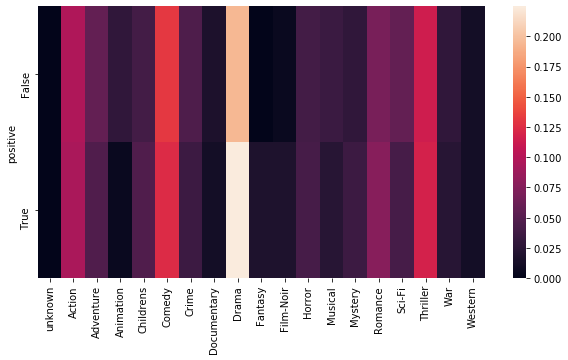

In [19]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 


user_item_df = pd.read_pickle("data/user_item_df.p")

def plot_heat_map(df, figsize=(10,7)): 
    df = df.div(df.sum(axis=1), axis=0)     
    plt.subplots(figsize=figsize)
    sns.heatmap(df)

    
# test_user_idx = 89
test_user_idx = 200
u_id = user_inv_idx[test_user_idx]

tester_df = user_item_df[user_item_df['uid']==int(u_id)]
tester_df['positive'] = tester_df['rating'] >3 

review = tester_df[['positive']+genres].groupby(['positive']).sum()
plot_heat_map(review, figsize=(10,5))


test_positive_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']>3)][['title']]
print(test_positive_df[['title']])
test_negative_df = user_item_df[(user_item_df['uid']==int(u_id)) & (user_item_df['rating']<3)][['title']]
print(test_negative_df[['title']])

u_one_json = json.loads(results[test_user_idx])
    
    

print ("Recommended movie Ids for user #{} : {}".format(test_user_idx+1, [item_inv_idx[movie_id] for movie_id in u_one_json['labels']]))

for movie_id in u_one_json['labels']:
    i_id = item_inv_idx[movie_id]
    print (item_df[item_df['iid']==int(i_id)]['title'])

print ("Movie distances for user #{} : {}".format(test_user_idx+1,  [round(distance, 4) for distance in u_one_json['distances']]))

In [20]:
popularity = user_item_df[user_item_df['rating']>3].groupby('iid').count()['uid'].to_dict() 
answer = {} 
for ui in test_user_item: 
    uid = ui[0]
    iid = ui[1]
    rating = ui[2]
    if uid not in answer:  
        answer[uid] = set() 
        if rating > 1: 
            answer[uid].add(iid)
    
all_pop = 0 
hits = 0 
topk = 10
valid_user_nb = 0 
rcmded = set()

for uid in answer.keys():
    if uid in transformer.train_users: 
        cuidx = transformer.u_idx[uid] 
        u_one_json = json.loads(results[cuidx])
        pred = set()
        valid_user_nb += 1 
        for i, movieid in enumerate(u_one_json['labels'][:topk]): 
            rcmded.add(movieid)
            if int(item_inv_idx[movieid]) in popularity: 
                all_pop += popularity[int(item_inv_idx[movieid])] 
            pred.add(item_inv_idx[movieid])
        
        hits += len(pred.intersection(answer[uid]))
print(all_pop/topk/valid_user_nb)
print(len(answer))
print(hits)
print(len(rcmded))

42.599999999999994
301
0
320
